### Mine PubMed for Cancer, Pathology and the techniques used in Image Processing


This notebook is a small version of the similarly named notebook, which focused in cancer and other conditions,  but this one is to compare techniques used in Pathology

#### Reference
Reyes-Aldasoro CC (2017) The proportion of cancer-related entries in PubMed has increased considerably; is cancer truly “The Emperor of All Maladies”? PLoS ONE 12(3): e0173671. https://doi.org/10.1371/journal.pone.0173671

First, import all the things you need to import.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from urllib.error import HTTPError, URLError
from scipy import interpolate
from socket import timeout
import logging

Then you can define the time of study, that is the years that you will be mining the data base. If you (don't) want to visualise which specific year, comment/uncomment the second line. NLTK is used to process the data per year so import if necessary.

In [61]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sbbk034\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
from nltk.tokenize import word_tokenize

Here is where the problem is defined. First we need to define a basic URL. And that will be the address of PubMed with a search term. This give entry to the database MEDLINE of the United States National Library of Medicine (NLM) and its search engine PubMed (https://www.ncbi.nlm.nih.gov/pubmed) have grown to include over 26 million entries: 26,710,394 on the 30 November 2016. 


Then, we will define a series of keywords. In MEDLINE, each entry is indexed with Medical Subject Headings (MeSH) and various field descriptors such as author, date, title, publication type, etc. These fields allow specific searches to be performed in PubMed by restricting the search to one, several or all fields and logical combinations with operators such as AND, OR, NOT are available as well. 

Then we add the actual keywords related to the actual conditions that we want to observe. Let's do this for: **Pathology, Cancer** and **Image Analysis/Processing**.

In [3]:
#Basic keywords, to be concatenated later concatenate
basicURL                = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='
allF                    = '%5BAll%20Fields%5D%29' # all fields code


KW_Pathology            =  '%20(%22pathology%22'+allF  #'%5BAll%20Fields%5D';
KW_Cancer               =  '%20AND%20(%22cancer%22'+allF
KW_ImageAnalysis        =  '%20AND+%28%28%22image+processing%22'+allF+'+OR+%28%22image+analysis%22'+allF+'+%29'


Add now the particular keywords that describe the techniques used.

In [4]:
keywords=[  'Thresholding','Transfer Learning','Machine Learning',
            'scale space','tracing','tracking','clustering',
            'geometric','biomarker','machine learning','segmentation',
            'region growing','hessian','multiresolution','texture',
            'feature extraction','principal component analysis',
            'linear discriminant analysis','ensemble','mutual information',
            'self-organizing maps','convolutional neural','linear regression',
            'deep learning','transfer learning','']

numKeywords = len(keywords)
yearsAnalysis = np.arange(1970,2023)

The spaces in the keywords will have to be replaced with %20 for the urls later on. Create a matrix where the entries obtained from the mining will be stored

In [97]:
entries_per_KW = np.zeros((numKeywords,len(yearsAnalysis))) # keyword (and total) and year
entries_per_KW.shape

(26, 53)

Notice the last keyword, which is actually blank. This is because we want also to retrieve all entries of a given year. Next, we concatenate all the keywords into a vector (or matrix, or whichever name is the correct in Python), and loop over the keywords. 


The whole record from PubMed is stored in *wholeURL*, towards the end, there is a section with the data per year in a format more or less like this:

```
 timelineData: {
        yearCounts: "[[1985, 1], [1986, 1], [1987, 1], [1988, 1], [1989, 2], [1990, 2], [1992, 2], [1993, 4], [1994, 2], [1995, 2], [1996, 2], [1997, 2], [1998, 3], [2000, 1], [2001, 6], [2002, 2], [2004, 1], [2005, 1], [2006, 2], [2008, 2], [2009, 1], [2010, 3], [2011, 3], [2012, 1], [2013, 3], [2014, 1], [2016, 5], [2017, 4], [2018, 3], [2019, 6], [2020, 3], [2021, 0]]",
        startYear: null,
        endYear: null
      },
```

The data of interest is delimited by the words *yearCounts* and *startYear*. The list can be tokenised so that each year and number of entries are stored in a list, and the following characters (each inside a token) need to be removed ' [ ] , '.

Then, the years are separated from the actual entries and stored in their corresponding location of the matrix


In [121]:
for index_kw,kw in enumerate(keywords):
    urlAddress          = basicURL+KW_Pathology+KW_Cancer+KW_ImageAnalysis+'%20AND%20%28%22'+str.replace(kw,' ','%20')+'%22'+allF
    #print(urlAddress)
    print(index_kw)
    with urllib.request.urlopen(urlAddress,  timeout=50) as url:
        wholeURL =  url.read().decode('utf-8')

        location_init = wholeURL.index('yearCounts')
        location_fin  = wholeURL.index('startYear')
        years_tokens  = word_tokenize(wholeURL[location_init+14:location_fin-11])
        years_tokens2 = [w for w in years_tokens if not w in '[],']
        years         = years_tokens2[::2]
        num_entries   = years_tokens2[1::2]
        for index_year, val_year in enumerate(years) :
            entries_per_KW[index_kw,round(float(val_year))-1970] = float(num_entries[index_year])
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [122]:
entries_per_KW[numKeywords-1]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
         2.,   6.,   5.,   7.,  11.,   6.,  12.,  22.,  46.,  44.,  54.,
        68.,  81., 112., 104., 120., 128., 116., 131., 152., 136., 143.,
       151., 212., 206., 194., 259., 218., 235., 271., 303., 310., 359.,
       454., 525., 514., 553., 637., 745., 655., 437.,   4.])

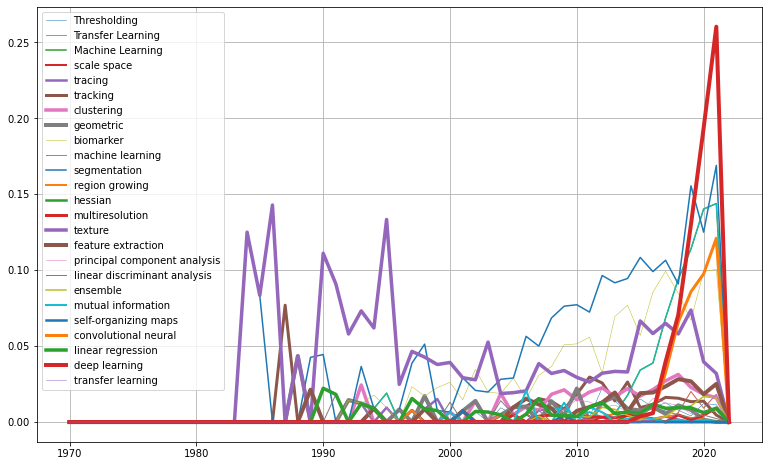

In [123]:
type_lines=['-','--',':','-.']
fig = plt.figure( figsize=(13, 8))
ax  = fig.add_subplot(111)
for index_kw,kw in enumerate(keywords[:-1]):
    plt.plot(yearsAnalysis,entries_per_KW[index_kw,:]/(1+entries_per_KW[numKeywords-1]),label=kw, linestyle='-',linewidth=0.5+0.5*np.mod(index_kw,8))  #,  marker='.', color='b',markersize = 5)
    #plt.plot(yearsAnalysis,entries_per_KW[index_kw,:]/(1+entries_per_KW[numKeywords-1]),label=kw, linestyle=type_lines[np.mod(index_kw,4)],linewidth=0.5+0.5*np.mod(index_kw,8))  #,  marker='.', color='b',markersize = 5)


plt.legend(loc="upper left")
plt.grid()


In [49]:
entries_per_KW_rel = np.zeros((numKeywords-1,len(yearsAnalysis)))
for index_kw,kw in enumerate(keywords[:-1]):
    entries_per_KW_rel[index_kw,:] =     entries_per_KW[index_kw,:]/(1+entries_per_KW[numKeywords-1])

In [50]:
entries_per_KW_rel.shape

(25, 53)

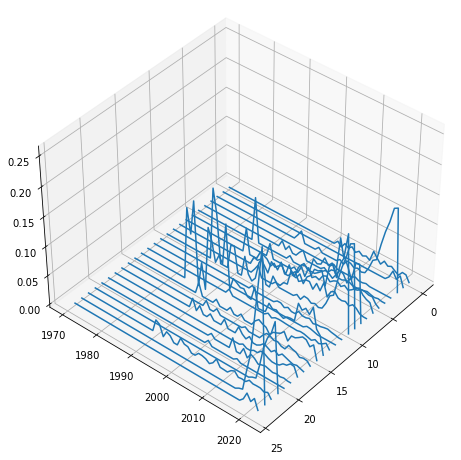

In [111]:
x, y = np.meshgrid(np.arange(0,numKeywords-1),yearsAnalysis,  indexing='ij')

from mpl_toolkits.mplot3d import axes3d


fig, ax1 = plt.subplots(
    1, 1, figsize=(15, 8), subplot_kw={'projection': '3d'})

ax1.plot_wireframe(x, y, entries_per_KW_rel, rstride=1, cstride=0)
ax1.view_init(elev=40., azim=40.)



In [56]:
ax1.view_init(elev=10., azim=10.)


In [34]:
X.shape

(120, 120)

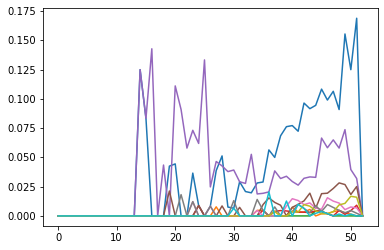

In [120]:
plt.plot(entries_per_KW_rel[10:20].T)